In [1]:
## Authenticate and mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My Drive/X_ray_photos/

/content/drive/My Drive/X_ray_photos


In [3]:
!ls

covid19  foo.png  model.png  normal  test  train  validation


### Importing libraries

In [3]:
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16


import os
import glob
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
base_dir = !pwd
base_dir = base_dir[0]
print(base_dir)
print(type(base_dir))

/content/drive/My Drive/X_ray_photos
<class 'str'>


In [ ]:
# classes = ['covid19', 'normal']

In [ ]:
# # The code below creates a train and a val folder each containing 2 folders (one for each type of X_ray image).
# # It then copies the images from the original folders to these new folders such that 75% of the images go
# # to the training set and 25% of the images go into the validation set.

# for i in classes:

#   os.makedirs(base_dir +'/train/' + i)
#   os.makedirs(base_dir +'/validation/' + i)
#   source = base_dir + '/' + i
#   allFileNames = os.listdir(source)
#   np.random.shuffle(allFileNames)
#   test_ratio = 0.25

#   train_FileNames, test_FileNames = np.split(np.array(allFileNames),
#                                                       [int(len(allFileNames)* (1 - test_ratio))])

#   train_FileNames = [source+'/'+ name for name in train_FileNames.tolist()]
#   test_FileNames = [source+'/' + name for name in test_FileNames.tolist()]

#   for name in train_FileNames:
#     shutil.copy(name, base_dir +'/train/' + i)

#   for name in test_FileNames:
#     shutil.copy(name, base_dir +'/validation/' + i)

In [ ]:
!ls

covid19  foo.png  model.png  normal  test  train  validation


In [5]:
# Setting paths for training an validation sets
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [6]:
print(train_dir)
print(val_dir)
print(test_dir)
print(type(train_dir))

/content/drive/My Drive/X_ray_photos/train
/content/drive/My Drive/X_ray_photos/validation
/content/drive/My Drive/X_ray_photos/test
<class 'str'>


In [7]:
BATCH_SIZE = 15  # Number of training examples to process before updating our models variables
IMG_SHAPE  = 224  # Our training data consists of images with width of 180 pixels and height of 180 pixels

In [8]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
      img = img.reshape((224,224))
      ax.imshow(img, cmap='gray')
    plt.tight_layout()
    plt.show()

In [9]:
# Read images from the disk.
# Decode contents of these images and convert it into proper grid format as per their RGB content.
# Convert them into floating point tensors.
# Rescale the tensors from values between 0 and 255 to values between 0 and 1, 
# as neural networks prefer to deal with small input values.
image_gen_train = ImageDataGenerator(rescale=1./255,
                    rotation_range=45,                   
                    horizontal_flip=True,
                    zoom_range=0.5
                    )

train_data_gen = image_gen_train.flow_from_directory(
                                                batch_size=BATCH_SIZE,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(IMG_SHAPE, IMG_SHAPE),
                                                class_mode='binary' 
                                                )

Found 194 images belonging to 2 classes.


In [18]:
print(train_data_gen[0][0].shape)

(15, 224, 224, 3)


In [ ]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]

In [ ]:
# plotImages(augmented_images)

In [10]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory=val_dir,
                                                 shuffle=False,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='binary')

test_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory=test_dir,
                                                 shuffle=False,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='binary')

Found 66 images belonging to 2 classes.
Found 32 images belonging to 2 classes.


In [61]:
val_data_gen[2][1].shape

(15,)

In [11]:
sample_training_images, _ = next(train_data_gen) 

# next function returns a batch from the dataset. One batch is a tuple of (many images, many labels).
# For right now, we're discarding the labels because we just want to look at the images.

In [ ]:
# plotImages(sample_training_images[:5])  # Plot images 0-4

### Creating model

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, Activation, AveragePooling2D
import math
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


In [62]:
baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(1, activation="sigmoid")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

In [ ]:
# cnn = Sequential()

# cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(IMG_SHAPE, IMG_SHAPE, 1)))
# cnn.add(MaxPooling2D(pool_size = (2, 2)))

# cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(IMG_SHAPE, IMG_SHAPE, 1)))
# cnn.add(MaxPooling2D(pool_size = (2, 2)))

# cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(IMG_SHAPE, IMG_SHAPE, 1)))
# cnn.add(MaxPooling2D(pool_size = (2, 2)))

# cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(IMG_SHAPE, IMG_SHAPE, 1)))
# cnn.add(MaxPooling2D(pool_size = (2, 2)))

# cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(IMG_SHAPE, IMG_SHAPE, 1)))
# cnn.add(MaxPooling2D(pool_size = (2, 2)))

# cnn.add(Flatten())

# cnn.add(Dense(activation = 'relu', units = 128))
# cnn.add(Dense(activation = 'relu', units = 64))

# cnn.add(Dense(activation = 'sigmoid', units = 1))

In [63]:
# compile our model
EPOCHS = 25
INIT_LR = 1e-3
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

print("[INFO] compiling model...")

model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])
# train the head of the network

print("[INFO] training head...")


[INFO] compiling model...
[INFO] training head...


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [64]:
history = model.fit_generator(
    train_data_gen,
    epochs=EPOCHS,
    validation_data=val_data_gen
    )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


Epoch 1/25
13/13 [==============================] - 101s 7s/step - loss: 0.6805 - accuracy: 0.5876 - val_loss: 0.5809 - val_accuracy: 0.7727
Epoch 2/25
13/13 [==============================] - 7s 508ms/step - loss: 0.6291 - accuracy: 0.6340 - val_loss: 0.5108 - val_accuracy: 0.9394
Epoch 3/25
13/13 [==============================] - 7s 507ms/step - loss: 0.5804 - accuracy: 0.7113 - val_loss: 0.4702 - val_accuracy: 0.9091
Epoch 4/25
13/13 [==============================] - 7s 509ms/step - loss: 0.5013 - accuracy: 0.8093 - val_loss: 0.4075 - val_accuracy: 0.9545
Epoch 5/25
13/13 [==============================] - 7s 517ms/step - loss: 0.4817 - accuracy: 0.8299 - val_loss: 0.3754 - val_accuracy: 0.9545
Epoch 6/25
13/13 [==============================] - 7s 519ms/step - loss: 0.4457 - accuracy: 0.8196 - val_loss: 0.3306 - val_accuracy: 0.9545
Epoch 7/25
13/13 [==============================] - 7s 520ms/step - loss: 0.4254 - accuracy: 0.8402 - val_loss: 0.3189 - val_accuracy: 0.9545
Epoch 8

### Visualizing CNN model

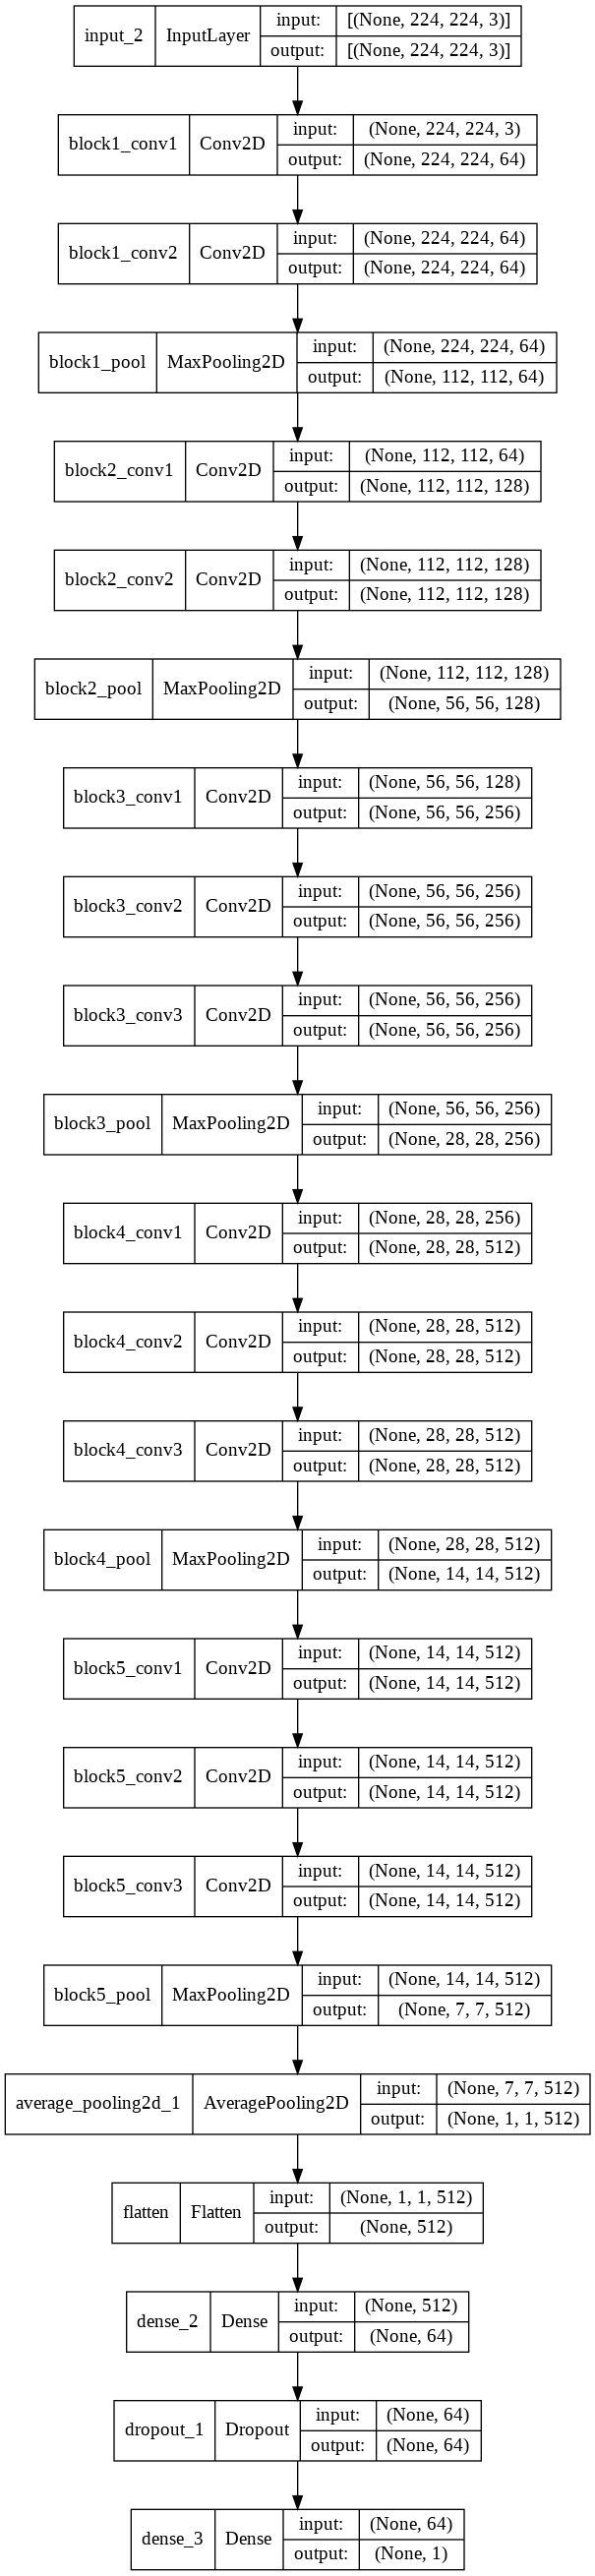

In [66]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

### Prediction and Results

In [68]:
test_accu = model.evaluate(test_data_gen)
print('The testing accuracy is :',test_accu[1]*100, '%')

3/3 [==============================] - 10s 5s/step - loss: 0.2084 - accuracy: 0.9062
The testing accuracy is : 90.625 %


In [70]:
preds = model.predict(test_data_gen,verbose=1)
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

3/3 [==============================] - 1s 345ms/step


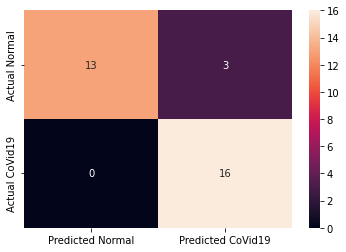

In [71]:
from sklearn.metrics import classification_report,confusion_matrix

cm = pd.DataFrame(data=confusion_matrix(test_data_gen.classes, predictions, labels=[0, 1]),index=["Actual Normal", "Actual CoVid19"],
columns=["Predicted Normal", "Predicted CoVid19"])

import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

In [72]:
print(classification_report(y_true=test_data_gen.classes,y_pred=predictions,target_names =['NORMAL','CoVid19']))

              precision    recall  f1-score   support

      NORMAL       1.00      0.81      0.90        16
     CoVid19       0.84      1.00      0.91        16

    accuracy                           0.91        32
   macro avg       0.92      0.91      0.91        32
weighted avg       0.92      0.91      0.91        32



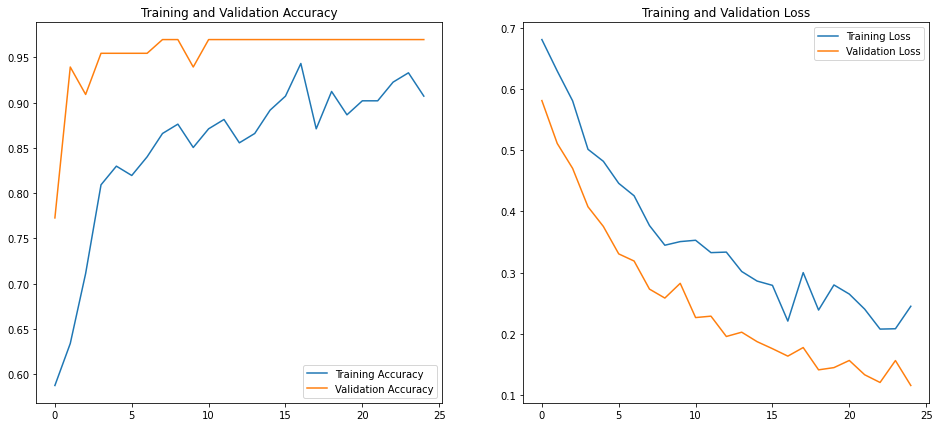

In [73]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./foo2.png')
plt.show()